In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from sklearn.utils import shuffle

In [2]:
df = pd.read_json('/home/leviathan/Downloads/News_Category_Dataset.json',lines=True)

In [3]:
df.drop(['date','link'],axis=1,inplace=True)

In [4]:
df.columns

Index(['authors', 'category', 'headline', 'short_description'], dtype='object')

In [5]:
df_down = df[df.category=='POLITICS']
df_down = df_down[:3500]
df  = df[df.category != 'POLITICS']

In [6]:
df = pd.concat([df,df_down])

In [7]:
df_down = df[df.category=='ENTERTAINMENT']
df_down = df_down[:3500]
df  = df[df.category != 'ENTERTAINMENT']
df = pd.concat([df,df_down])
df = shuffle(df)

In [8]:
df.shape

(84993, 4)

In [9]:
print(df.columns)
df['data'] = df.headline +" "+ df.authors
df.drop(['headline','short_description','authors'],axis=1,inplace=True)
df.head()

Index(['authors', 'category', 'headline', 'short_description'], dtype='object')


,category,data
99352,WOMEN,Feminism Is a Popularity Contest That I'm Losi...
35999,SPORTS,"Triple H ""Not Happy"" With NXT! 205 Live Troubl..."
99545,QUEER VOICES,Bryan Bishop Talks OUTVETS In Boston's St. Pat...
60002,CRIME,Louisiana Prisoner Freed After 41 Years Of Unc...
78938,SPORTS,UFC Champion Jon Jones Sentenced In Hit-And-Ru...


In [10]:
df['category_id'] = df['category'].factorize()[0]
category_id_df = df[['category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'category']].values)
df.head()

,category,data,category_id
99352,WOMEN,Feminism Is a Popularity Contest That I'm Losi...,0
35999,SPORTS,"Triple H ""Not Happy"" With NXT! 205 Live Troubl...",1
99545,QUEER VOICES,Bryan Bishop Talks OUTVETS In Boston's St. Pat...,2
60002,CRIME,Louisiana Prisoner Freed After 41 Years Of Unc...,3
78938,SPORTS,UFC Champion Jon Jones Sentenced In Hit-And-Ru...,1


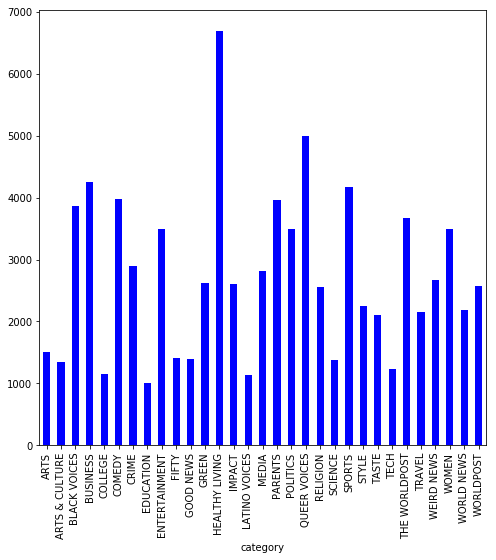

In [11]:
plt.figure(figsize=(8,8))
df.groupby('category').data.count().plot.bar(color='blue')
plt.show()

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features= tfidf.fit_transform(df.data)
labels = df.category_id
features.shape 

(84993, 31516)

/home/leviathan/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


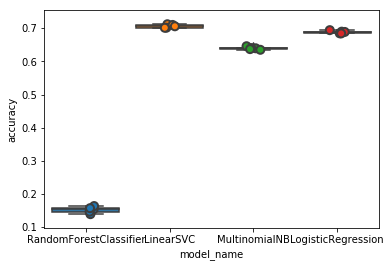

model_name
LinearSVC                 0.705986
LogisticRegression        0.688150
MultinomialNB             0.639333
RandomForestClassifier    0.152238
Name: accuracy, dtype: float64

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()
cv_df.groupby('model_name').accuracy.mean()

0.6995864232743868


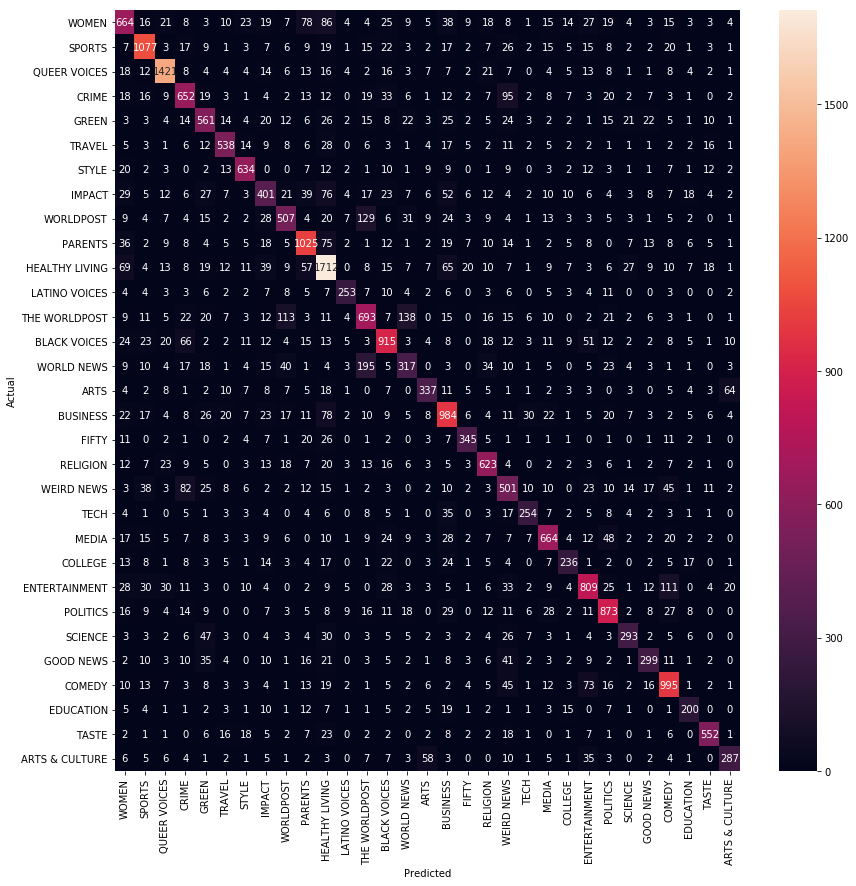

In [20]:
model = LinearSVC()
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
print(model.score(X_test,y_test))
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(14,14))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.category.values, yticklabels=category_id_df.category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()